In [33]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import pickle

from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')

In [34]:
# DATA PARAMETERS
DATASET_NAME = os.path.join("..", "data", "creditcard.csv")
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 120
# BATCH_SIZE = 100
LEARNING_RATE = 0.03
NUMBER_OF_NEURONS = 512
REGULARIZATION_LAMBDA = 0.1

In [51]:
# UTILS
def sigmoid(x):
    return np.multiply(0.5, (1 + np.tanh(np.multiply(0.5, x))))


def relu(x):
    return x.clip(min=0)


def sigmoid_derivative(x):
    return np.multiply(x, (1 - x))


def relu_derivative(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x


def accuracy_score(actual, predicted):
    predicted = predicted.reshape(-1, )
    actual = actual.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))

    return (TP + TN) / actual.shape[0]


def split_data(dataset, train_size=0.8):
    if isinstance(dataset, pd.core.frame.DataFrame):
        dataset = dataset.sample(frac=1)
    elif isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Pandas DataFrame required.')

    size = dataset.shape[0]
    return dataset[:int(train_size * size)], dataset[int(train_size * size):]


def k_fold_split_data(dataset, k=5):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array required.')

    return np.array_split(dataset, k)


def get_under_sample_dataset(dataset, train_and_validation):
    fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, fraud_indices.shape[0], replace=False))
    under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
    return dataset.iloc[under_sample_indices, :].sample(frac=1)

def get_radnom_normal_indices(dataset, train_and_validation, amount):
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, amount, replace=False))
    return dataset.iloc[random_normal_indices, :].sample(frac=1)

def plot_loss(epochs, training_history, validation_history):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, training_history, label='train_loss')
    ax.plot(x_axis, validation_history, label='val_loss')
    ax.legend()
    plt.ylabel('MSE')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    plt.show()


def plot_confusion_matrix(model, x, y):
    predicted = np.round(model.predict(x)).reshape(-1, )
    actual = y.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns=['actual 1', 'actual 0'],
                                    index=['predicted 1', 'predicted 0'])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    print('\nPrecision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-score: {}'.format(f1))
    print('\n')
    print(confusion_matrix)
    
    
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([-0.01, 1.01], [-0.01, 1.01],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    


In [36]:
# Read CSV
dataset = pd.read_csv(DATASET_NAME)

assert not dataset.isnull().values.any()
#dataset['Amount'] = StandardScaler().fit_transform(dataset[['Amount']])
dataset = dataset.drop(['Amount'],axis=1)
#dataset['Hour'] = dataset['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)
dataset = dataset.drop(['Time'],axis=1)
NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'
print(dataset.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...         V20       V21       V22  \
0  0.098698  0.363787  0.090794  ...    0.251412 -0.018307  0.277838   
1  0.085102 -0.255425 -0.166974  ...   -0.069083 -0.225775 -0.638672   
2  0.247676 -1.514654  0.207643  ...    0.524980  0.247998  0.771679   
3  0.377436 -1.387024 -0.054952  ...   -0.208038 -0.108300  0.005274   
4 -0.270533  0.817739  0.753074  ...    0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27       V28  Class  
0 -0.110474  0.066928  0.128539 -0.189115  0.

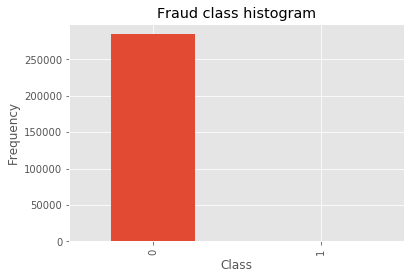

0    284315
1       492
Name: Class, dtype: int64

In [37]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [38]:
# Split dataset on train_and_validation dataset and test dataset
# train_and_validation, test = split_data(dataset, train_size=0.8)


In [39]:
# export train_and_validation and test dataset
# pickle.dump( train_and_validation, open(os.path.join("..", "data", "train_and_validation_dataset.data"), "wb" ))
# pickle.dump( test, open(os.path.join("..", "data", "test_dataset.data"), "wb" ))


In [40]:
# Load train_and_validation dataset
train_and_validation = pickle.load(open(os.path.join("..", "data", "train_and_validation_dataset.data"), "rb" ))


In [41]:
class Layer:
    def __init__(self, input_dim, neurons_number, learning_rate, activation):
        self.activation = activation
        self.learning_rate = learning_rate

        self.output_layer = True

        self.input = np.asmatrix(np.zeros((input_dim + 1, 1)))
        self.output = np.asmatrix(np.zeros((neurons_number, 1)))
        self.weights = np.asmatrix(np.random.uniform(low=-2/(input_dim**0.5), high=2/(input_dim**0.5), size=(input_dim + 1, neurons_number)))
        self.deltas = np.asmatrix(np.zeros((neurons_number, 1)))
        self.cumulative_gradient = np.asmatrix(np.zeros((input_dim + 1, neurons_number)))

    def _activate(self, x):
        if self.activation == 'sigmoid':
            return sigmoid(x)
        elif self.activation == 'relu':
            return relu(x)

    def _get_gradient(self):
        return np.matmul(self.input, self.deltas.transpose())

    def forward_step(self, input_data):
        self.input = np.concatenate([[[1]], input_data])  # Add bias
        self.output = self._activate(np.matmul(self.weights.transpose(), self.input))
        return self.output

    def backward_step(self, next_weights=None, next_deltas=None, output_delta=None):
        if self.output_layer:
            self.deltas = output_delta
        else:
            derivative_of_activation = self.get_activation_derivative(self.output)
            self.deltas = np.multiply(np.matmul(np.delete(next_weights, 0, 0), next_deltas),
                                      derivative_of_activation)  # Exclude bias row from weights

        self.cumulative_gradient = self.cumulative_gradient + self._get_gradient()

    def get_activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return sigmoid_derivative(x)
        elif self.activation == 'relu':
            return relu_derivative(x)

    def get_deltas(self):
        return self.deltas

    def get_weights(self):
        return self.weights


class NeuralNetwork:
    def __init__(self, learning_rate, batch_size=50, epochs=20, loss='mse', regular_lambda=0.1):
        self.layers = []
        self.lerning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.loss = loss
        self.regular_lambda = regular_lambda

        self.training_history = []
        self.validation_history = []

    def _global_forward_step(self, x_train_batch):
        y_predicted_batch = []
        for x_train_record in x_train_batch:
            x_train_record = x_train_record.reshape((-1, 1))
            for layer in self.layers:
                x_train_record = layer.forward_step(x_train_record)
            y_predicted_batch.append(x_train_record)

        return np.concatenate(y_predicted_batch)

    def _global_backward_step(self, y_predicted_record, y_train_record):

        output_delta = self._count_output_delta(y_predicted_record, y_train_record)

        output_layer = self.layers[-1]
        output_layer.backward_step(output_delta=output_delta)

        next_deltas = output_layer.get_deltas()
        next_weights = output_layer.get_weights()

        for layer in reversed(self.layers[:-1]):
            layer.backward_step(next_weights=next_weights, next_deltas=next_deltas)

    def _count_output_delta(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.sum(np.multiply((y_predicted - y_actual), self.layers[-1].get_activation_derivative(y_predicted)), axis=0)

    def _save_loss(self, x_tr, y_tr, x_val, y_val):
        y_predicted_train = self._global_forward_step(x_tr)
        train_loss = self._count_loss(y_predicted_train, y_tr)
        self.training_history.append(train_loss)

        if x_val is not None and y_val is not None:
            y_predicted_validation = self._global_forward_step(x_val)
            validation_loss = self._count_loss(y_predicted_validation, y_val)
            self.validation_history.append(validation_loss)

        print("Loss: ", train_loss, " Accuracy: ", accuracy_score(y_tr, np.round(y_predicted_train)))

    def _count_loss(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.average(np.square(y_actual - y_predicted))

    def add_layer(self, input_dim, neurons_number, activation='sigmoid'):
        layer = Layer(input_dim, neurons_number, learning_rate=self.lerning_rate, activation=activation)
        if self.layers:
            self.layers[-1].output_layer = False
        self.layers.append(layer)

    def fit(self, x_train, y_train, x_val=None, y_val=None, distinct = 0):
        print(x_train.shape, y_train.shape)
        tr = np.hstack((x_train, y_train))
        tr_f = tr[tr[:, -1] == 1]
        tr_n = tr[tr[:, -1] == 0]
        tr_f_ep = tr_f
        tr_n_ep = tr_n
        tr_score = np.concatenate((tr_f_ep, tr_n[: tr_f.shape[0],:]))
        #print("FIT: tyle jest frauds:", tr_f.shape)
        #print("FIT: tyle jest normals:", tr_n.shape)
        for i in range(self.epochs):
            if(distinct):
                tr_n = np.roll(tr_n, tr_f.shape[0])
                tr_n_ep = tr_n[: tr_f.shape[0],:]
                tr = np.concatenate((tr_f_ep, tr_n_ep))
                x_tr = tr[:,:-1]
                y_tr = tr[:,-1:]
                
            else:
                x_tr = x_train
                y_tr = y_train
                
            # zeby w kazdej epoce byly inne dobre i te same zle ( w jednej walidacji oczywiscie)
            
            for idx in range(0, x_tr.shape[0], self.batch_size):
                x_train_batch = x_tr[idx:idx + self.batch_size]
                y_train_batch = y_tr[idx:idx + self.batch_size]

                for n, x_train_record in enumerate(x_train_batch):
                    x_train_record = x_train_record.reshape(1, -1)
                    y_predicted_record = self._global_forward_step(x_train_record)
                    self._global_backward_step(y_predicted_record, y_train_batch[n])

                for lyr in self.layers:
                    gradient = lyr.cumulative_gradient / x_train_batch.shape[0] + self.regular_lambda * lyr.weights
                    lyr.weights = lyr.weights - np.multiply(self.lerning_rate, gradient)
                    lyr.cumulative_gradient = np.asmatrix(np.zeros(lyr.cumulative_gradient.shape))
            self._save_loss(tr_score[:,:-1], tr_score[:,-1:], x_val, y_val)

    def predict(self, x):
        return self._global_forward_step(x)

    def evaluate(self, x, y):
        y_predicted = self._global_forward_step(x)
        loss = self._count_loss(y_predicted, y)

        print("Loss: ", loss)
        print("Accuracy: ", accuracy_score(y, np.round(y_predicted)))

In [42]:
#Create array with only bad transactions for test&validation
fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
fraud_indices = dataset.iloc[fraud_indices, :].sample(frac=1)
fraud_indices = fraud_indices.values

kfold_split_frauds = k_fold_split_data(fraud_indices, N_SPLITS)
kfold_split_frauds_lens = [len(x) for x in kfold_split_frauds]

normal_total = np.array(train_and_validation[train_and_validation.Class == 0].index)
normal_total_df = dataset.iloc[normal_total, :].sample(frac=1)
normal_total = normal_total_df.values
print(normal_total)

np.random.shuffle(normal_total)
normal_validation_indices = normal_total[:fraud_indices.shape[0], :]
normal_train = normal_total[fraud_indices.shape[0]:, :]

kfold_split_normals = k_fold_split_data(normal_validation_indices, N_SPLITS)

print(normal_train.shape, normal_validation_indices.shape, normal_total.shape)

# k-fold validation with k=5
models = []

[[ 1.31125849  0.07502777 -1.2928324  ..., -0.02183661  0.02363838  0.        ]
 [ 1.24590198 -0.43871453  0.88492388 ...,  0.08551132  0.03262617  0.        ]
 [ 0.14887056  1.05211279 -0.40872921 ...,  0.22376192  0.08451823  0.        ]
 ..., 
 [ 1.03757211 -0.33327188  1.20322329 ...,  0.04464496  0.0115034   0.        ]
 [ 2.04540926  0.07184454 -1.81688909 ..., -0.06549266 -0.04496777  0.        ]
 [-0.37442953  0.44121781  2.01932693 ...,  0.07417494  0.14512983  0.        ]]
(227065, 29) (390, 29) (227455, 29)


In [43]:
for k, validation_frauds in enumerate(kfold_split_frauds):
    #Get train frauds from train&validation frauds
    train_frauds = kfold_split_frauds.copy()
    train_frauds.pop(k)
    train_frauds = np.concatenate(train_frauds)
    print(len(train_frauds))
    
    validation_normals = kfold_split_normals[k]
    np.random.shuffle(normal_train)
    train_normals = normal_train[:train_frauds.shape[0]*EPOCHS,:]
    
    train = np.concatenate([train_frauds, train_normals])
    
    x_train = train[:, :-1]
    y_train = train[:, -1:]
    
    validation = np.concatenate([validation_frauds,validation_normals])
    np.random.shuffle(validation)

    x_validation = validation[:, :-1]
    y_validation = validation[:, -1:]

    model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
    model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
    model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
    model.fit(x_train, y_train, x_validation, y_validation, distinct=1)

    print("\n", '='*80)
    print("\nValidation dataset evaluation:")
    model.evaluate(x_validation, y_validation)
    print("\n")
    models.append(model)


312
(37752, 28) (37752, 1)
Loss:  0.541883707066  Accuracy:  0.27724358974358976
Loss:  0.516188289587  Accuracy:  0.27724358974358976
Loss:  0.438551883819  Accuracy:  0.296474358974359
Loss:  0.228181924523  Accuracy:  0.5737179487179487
Loss:  0.21021879976  Accuracy:  0.5785256410256411
Loss:  0.197392251001  Accuracy:  0.6089743589743589
Loss:  0.187834106358  Accuracy:  0.6474358974358975
Loss:  0.178879414374  Accuracy:  0.6634615384615384
Loss:  0.169338720244  Accuracy:  0.6987179487179487
Loss:  0.163119151682  Accuracy:  0.717948717948718
Loss:  0.156473244252  Accuracy:  0.7451923076923077
Loss:  0.150760714489  Accuracy:  0.7516025641025641
Loss:  0.146064792791  Accuracy:  0.7580128205128205
Loss:  0.141437544507  Accuracy:  0.780448717948718
Loss:  0.137280521461  Accuracy:  0.7900641025641025
Loss:  0.133041100709  Accuracy:  0.7932692307692307
Loss:  0.129495020573  Accuracy:  0.8125
Loss:  0.126905657451  Accuracy:  0.8173076923076923
Loss:  0.124791616023  Accuracy: 

Loss:  0.0919829802071  Accuracy:  0.9118589743589743
Loss:  0.0913718965808  Accuracy:  0.9134615384615384
Loss:  0.0905180498485  Accuracy:  0.9182692307692307
Loss:  0.0896557787262  Accuracy:  0.9214743589743589
Loss:  0.0888417803085  Accuracy:  0.9262820512820513
Loss:  0.087758468839  Accuracy:  0.9278846153846154
Loss:  0.0871035063567  Accuracy:  0.9310897435897436
Loss:  0.0862780135122  Accuracy:  0.9310897435897436
Loss:  0.0855231795183  Accuracy:  0.9326923076923077
Loss:  0.0846672227431  Accuracy:  0.9310897435897436
Loss:  0.0841256569046  Accuracy:  0.9342948717948718
Loss:  0.0834150998891  Accuracy:  0.9326923076923077
Loss:  0.0827873571438  Accuracy:  0.9326923076923077
Loss:  0.0821927240482  Accuracy:  0.9342948717948718
Loss:  0.0819342246741  Accuracy:  0.9358974358974359
Loss:  0.0816230918855  Accuracy:  0.9358974358974359
Loss:  0.0815271237199  Accuracy:  0.9358974358974359
Loss:  0.0809503049813  Accuracy:  0.9358974358974359
Loss:  0.0802729296958  Accur

Loss:  0.0733983358723  Accuracy:  0.9278846153846154
Loss:  0.0732517772796  Accuracy:  0.9294871794871795
Loss:  0.0729735162877  Accuracy:  0.9278846153846154
Loss:  0.0727496013171  Accuracy:  0.9278846153846154
Loss:  0.0725238271617  Accuracy:  0.9278846153846154
Loss:  0.0723146588263  Accuracy:  0.9278846153846154
Loss:  0.0720745280502  Accuracy:  0.9294871794871795
Loss:  0.0719527822795  Accuracy:  0.9310897435897436
Loss:  0.0717914786746  Accuracy:  0.9310897435897436
Loss:  0.0716988770255  Accuracy:  0.9310897435897436
Loss:  0.0715529152364  Accuracy:  0.9326923076923077
Loss:  0.0714137844943  Accuracy:  0.9375
Loss:  0.0712751754201  Accuracy:  0.9375
Loss:  0.0710662420856  Accuracy:  0.9342948717948718
Loss:  0.0708770424243  Accuracy:  0.9342948717948718
Loss:  0.070742004151  Accuracy:  0.9326923076923077
Loss:  0.0706096359194  Accuracy:  0.9326923076923077
Loss:  0.0704261248067  Accuracy:  0.9326923076923077
Loss:  0.0702248374567  Accuracy:  0.9310897435897436

Loss:  0.070172338849  Accuracy:  0.9262820512820513
Loss:  0.0699708050629  Accuracy:  0.9262820512820513
Loss:  0.069774573299  Accuracy:  0.9246794871794872
Loss:  0.0697008733923  Accuracy:  0.9262820512820513
Loss:  0.0697692204563  Accuracy:  0.9278846153846154
Loss:  0.0697447744803  Accuracy:  0.9278846153846154
Loss:  0.0697316185562  Accuracy:  0.9278846153846154
Loss:  0.0697425754884  Accuracy:  0.9278846153846154
Loss:  0.069809890885  Accuracy:  0.9294871794871795
Loss:  0.0699377943206  Accuracy:  0.9294871794871795
Loss:  0.0698152140408  Accuracy:  0.9294871794871795
Loss:  0.0697801513926  Accuracy:  0.9294871794871795
Loss:  0.0698713167528  Accuracy:  0.9294871794871795
Loss:  0.0698595688124  Accuracy:  0.9294871794871795
Loss:  0.0697043809342  Accuracy:  0.9294871794871795
Loss:  0.0697080780133  Accuracy:  0.9294871794871795
Loss:  0.0696595763506  Accuracy:  0.9294871794871795
Loss:  0.0695709165528  Accuracy:  0.9278846153846154
Loss:  0.0695594861289  Accurac

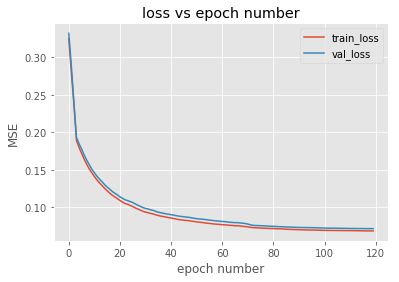

In [44]:
training_history = np.average([mdl.training_history for mdl in models], axis=0)
validation_history = np.average([mdl.validation_history for mdl in models], axis=0)

plot_loss(EPOCHS, training_history, validation_history)


# EVALUATION ON TEST DATASET

In [45]:
# Read test dataset
test = pickle.load(open(os.path.join("..", "data", "test_dataset.data"), "rb" ))

# Convert test data to numpyarray and split them.
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]

print("\nTest dataset evaluation:")
train_and_validation = train_and_validation.values 
x_train_and_validation = train_and_validation[:, :-1]
y_train_and_validation = train_and_validation[:, -1:]


Test dataset evaluation:


In [46]:
test_model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train_and_validation.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
test_model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
test_model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
test_model.fit(x_train_and_validation, y_train_and_validation, distinct=1)

(227845, 28) (227845, 1)
Loss:  0.205191044803  Accuracy:  0.6166666666666667
Loss:  0.190596049043  Accuracy:  0.6487179487179487
Loss:  0.18045565901  Accuracy:  0.6730769230769231
Loss:  0.171737037605  Accuracy:  0.6987179487179487
Loss:  0.163402215232  Accuracy:  0.7256410256410256
Loss:  0.156077785424  Accuracy:  0.7461538461538462
Loss:  0.148868018316  Accuracy:  0.7653846153846153
Loss:  0.142988636056  Accuracy:  0.782051282051282
Loss:  0.138040872812  Accuracy:  0.7974358974358975
Loss:  0.132938639916  Accuracy:  0.8115384615384615
Loss:  0.128046120379  Accuracy:  0.8243589743589743
Loss:  0.123229792232  Accuracy:  0.8320512820512821
Loss:  0.119604817246  Accuracy:  0.8435897435897436
Loss:  0.116027934025  Accuracy:  0.85
Loss:  0.112915471376  Accuracy:  0.8615384615384616
Loss:  0.110011840147  Accuracy:  0.8782051282051282
Loss:  0.1069778476  Accuracy:  0.8794871794871795
Loss:  0.104483985875  Accuracy:  0.8858974358974359
Loss:  0.102100342893  Accuracy:  0.889

In [47]:
test_model.evaluate(x_test, y_test)
plot_confusion_matrix(model, x_test, y_test)
# print(model.layers[0].weights)

Loss:  0.0732458343604
Accuracy:  0.978792879463502

Precision: 0.08773584905660377
Recall: 0.9117647058823529
F-score: 0.16006884681583478


             actual 1  actual 0
predicted 1        93       967
predicted 0         9     55893


100%|██████████| 21/21 [01:20<00:00,  3.83s/it]
/home/maciejpesko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


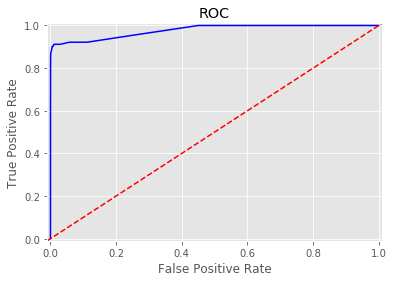

In [52]:
TPR_array = []
FPR_array = []
for i in tqdm(range(-50,55,5)):
    predicted = np.round(model.predict(x_test) + i/100).reshape(y_test.shape)
    actual = y_test  
    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    TPR_array.append(TP / (TP+FN))
    FPR_array.append(FP / (FP+TN))

plot_ROC(TPR_array, FPR_array)